In [1]:
import os
import pickle
import sys
_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.append(_path)

import astropy.coordinates as coord
import astropy.table as at
from astropy.io import fits
import astropy.units as u
import gala.coordinates as gc
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import healpy as hp
from tqdm.notebook import tqdm
from scipy.optimize import leastsq

from stream_helpers import get_data, rots

In [147]:
bass_cube, distmods, bass_footprint = get_data(
    bass_file='../data/BASS_iso_hpxcube_z0.0001_a13.5_gmax23.fits.gz', 
    bass_scale_factor=1)

decals_cube, distmods, decals_footprint = get_data(
    decals_file='../data/DECaLS_iso_hpxcube_z0.0001_a13.5_gmax23.fits.gz')

npix, nslice = bass_cube.shape
nside = hp.npix2nside(npix)

In [148]:
cubes = {'bass': bass_cube, 'decals': decals_cube}
footprints = {'bass': bass_footprint, 'decals': decals_footprint}

In [149]:
overlap = (footprints['bass'] * footprints['decals']).astype(bool)

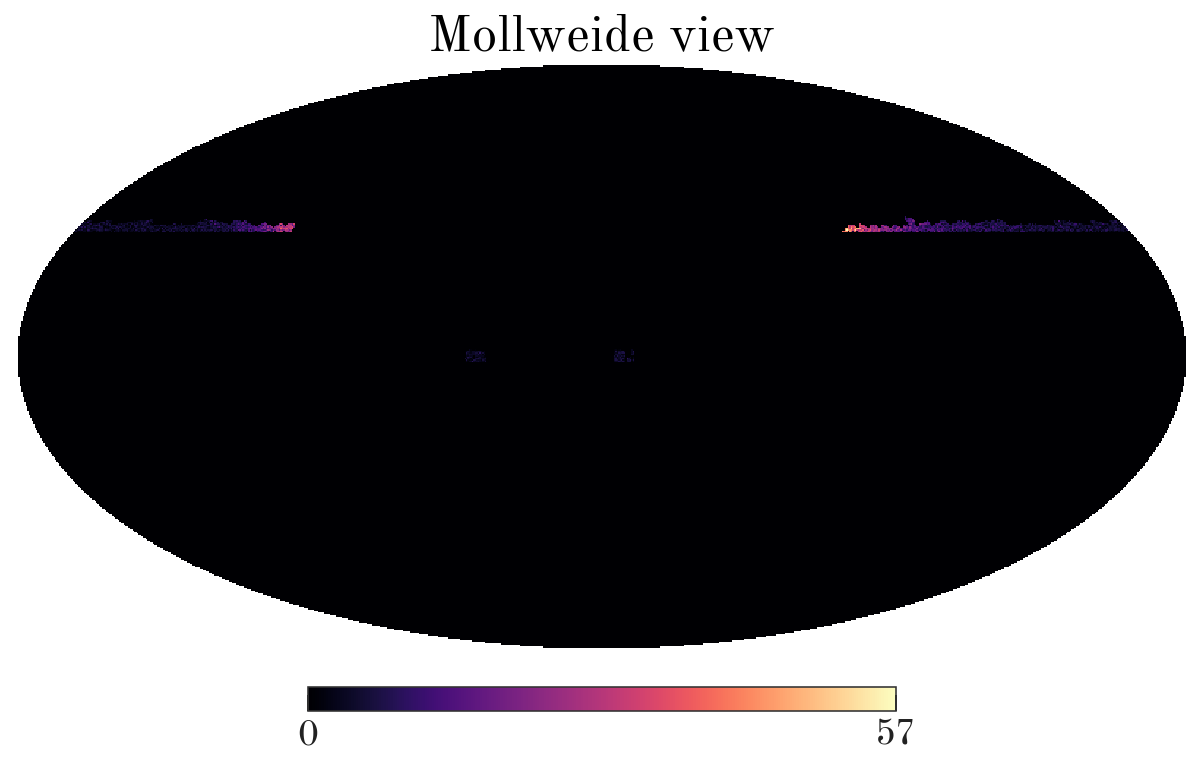

In [150]:
tmp = cubes['bass'][:, 0].copy()
tmp[~overlap] = 0.
hp.mollview(tmp)

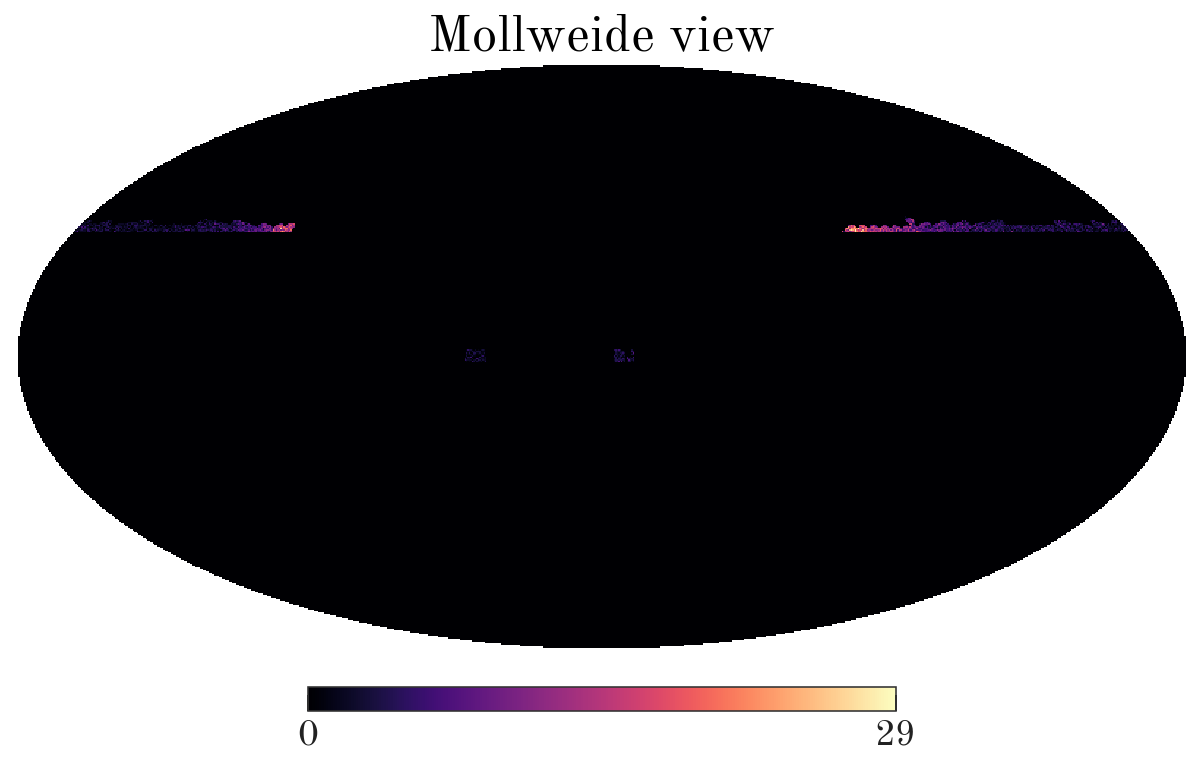

In [151]:
tmp = cubes['decals'][:, 0].copy()
tmp[~overlap] = 0.
hp.mollview(tmp)

In [240]:
def stitch_slice(bass, decals, overlap, bass_footprint, 
                 min_bass=0, min_decals=0):
    mask = (bass > min_bass) & (decals > min_decals) & overlap
    poly = np.poly1d(np.polyfit(bass[mask], decals[mask],
                                deg=1))
    
    overlap = overlap & (bass > 0) & (decals > 0)
    
    new_bass = poly(bass)
    stitched = decals.copy()
    stitched[bass_footprint] += new_bass[bass_footprint]
    stitched[overlap] *= 0.5
    
    return stitched

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


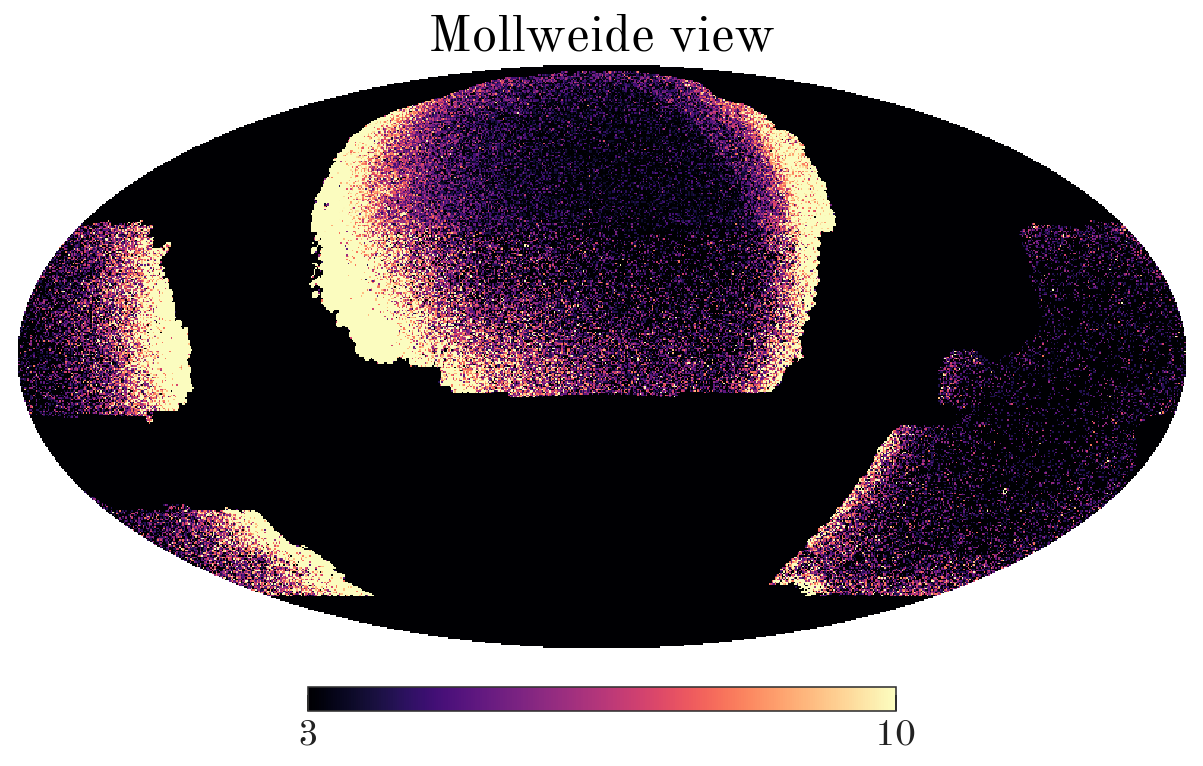

In [241]:
stitched = stitch_slice(cubes['bass'][:, 0], cubes['decals'][:, 0], 
                        overlap, footprints['bass'], 
                        min_bass=4)
hp.mollview(stitched, min=3, max=10, rot=[180, 0])

In [242]:
all_stitched = []
for i in range(nslice):
    stitched = stitch_slice(cubes['bass'][:, i], cubes['decals'][:, i], 
                            overlap, footprints['bass'], 
                            min_bass=4)
    all_stitched.append(stitched)
all_stitched = np.stack(all_stitched, axis=1)

In [243]:
slices = [(26, 50),
          (15, 26),
          (0, 15)]

slice_str = '_'.join(['{}-{}'.format(x,y) for x,y in slices])
dist = coord.Distance(distmod=distmods)
for x, y in slices:
    print(dist[x], dist[y])

20.892961308540322 kpc 63.09573444801878 kpc
12.589254117941637 kpc 20.892961308540322 kpc
6.309573444801931 kpc 12.589254117941637 kpc


In [244]:
def apwnorm(x, min=None, max=None):
    if min is None:
        min = np.nanmin(x[~np.isinf(x)])
    if max is None:
        max = np.nanmax(x[~np.isinf(x)])
    return np.clip((x - min) / (max - min), 0, 1)

In [245]:
stacks = np.stack([np.sum(all_stitched[:, x:y], axis=1) / (y - x) 
                   for x, y in slices], 
                  axis=-1)

rgb = np.zeros_like(stacks)
for i in range(3):
    X = stacks[..., i]
    rgb[..., i] = hp.smoothing(X, sigma=np.radians(0.15), verbose=False)
    rgb[X==0, i] = 0.

for i in range(3):
    X = stacks[..., i]
    
    rgb[..., i] = apwnorm(rgb[..., i], 
                          min=np.percentile(rgb[..., i], 1), #2.5), 
                          max=np.percentile(rgb[..., i], 99))
    # a = 1e-1
    # rgb[..., i] = np.arcsinh(rgb[..., i]/a) / np.arcsinh(1/a)
    
    rgb[X==0, i] = 0.

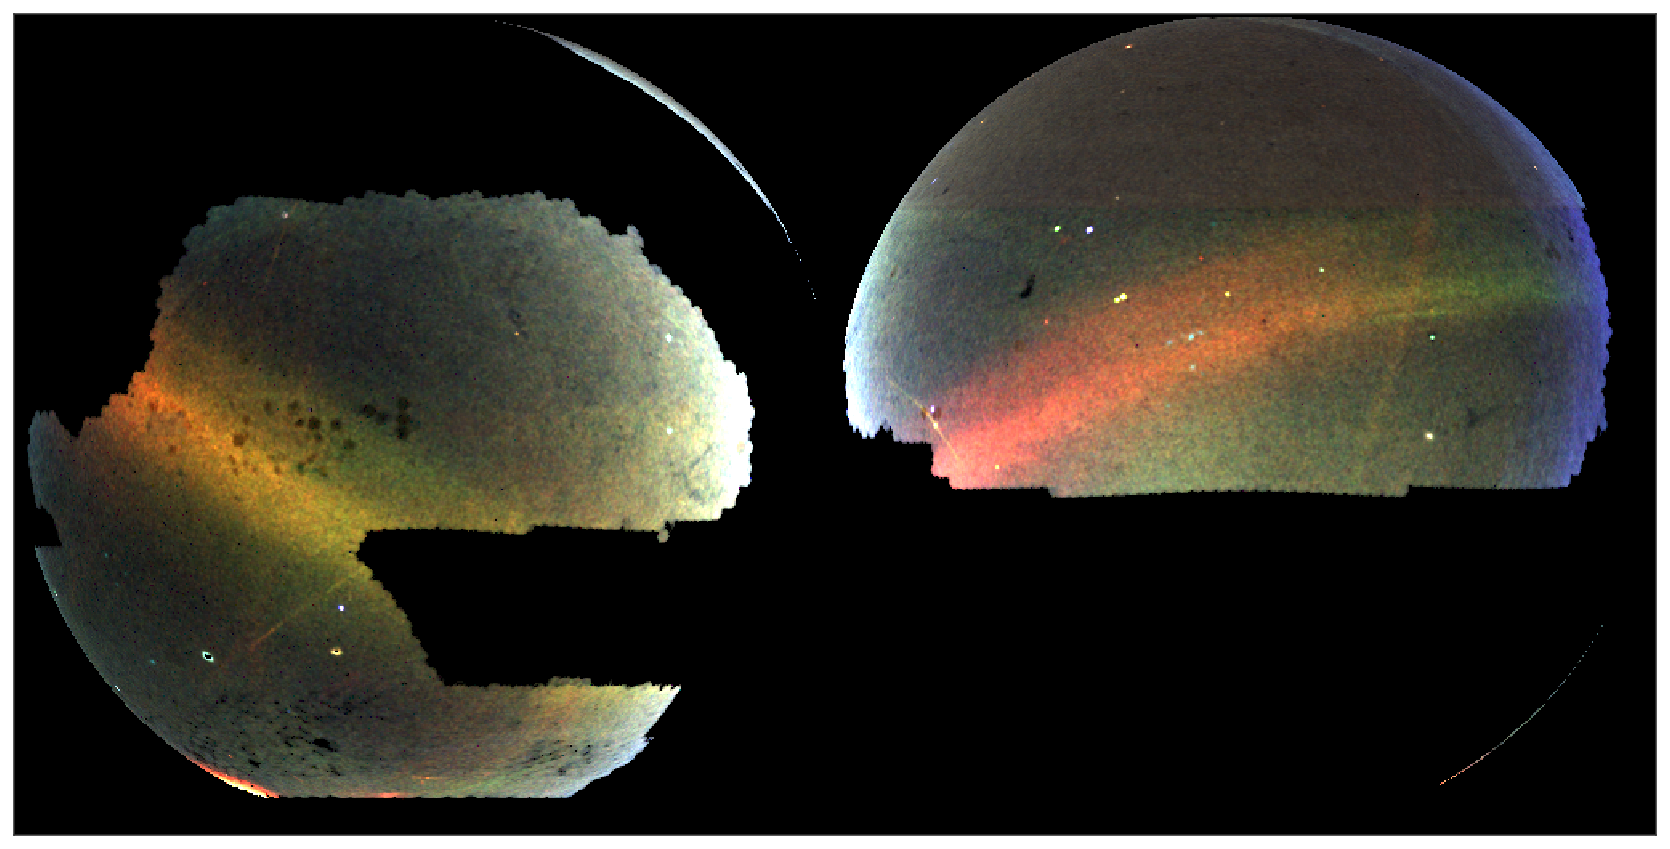

In [249]:
# proj = hp.projector.MollweideProj(rot=rots['sag']) 
# proj = hp.projector.MollweideProj(rot=[0, 90, 0], 
#                                   xsize=1024)
proj = hp.projector.OrthographicProj(xsize=1024, rot=[0, 0, 0])
func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

img = np.stack([proj.projmap(rgb[:, i], func) 
                for i in range(3)], axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(img, origin='bottom', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.tight_layout()

---

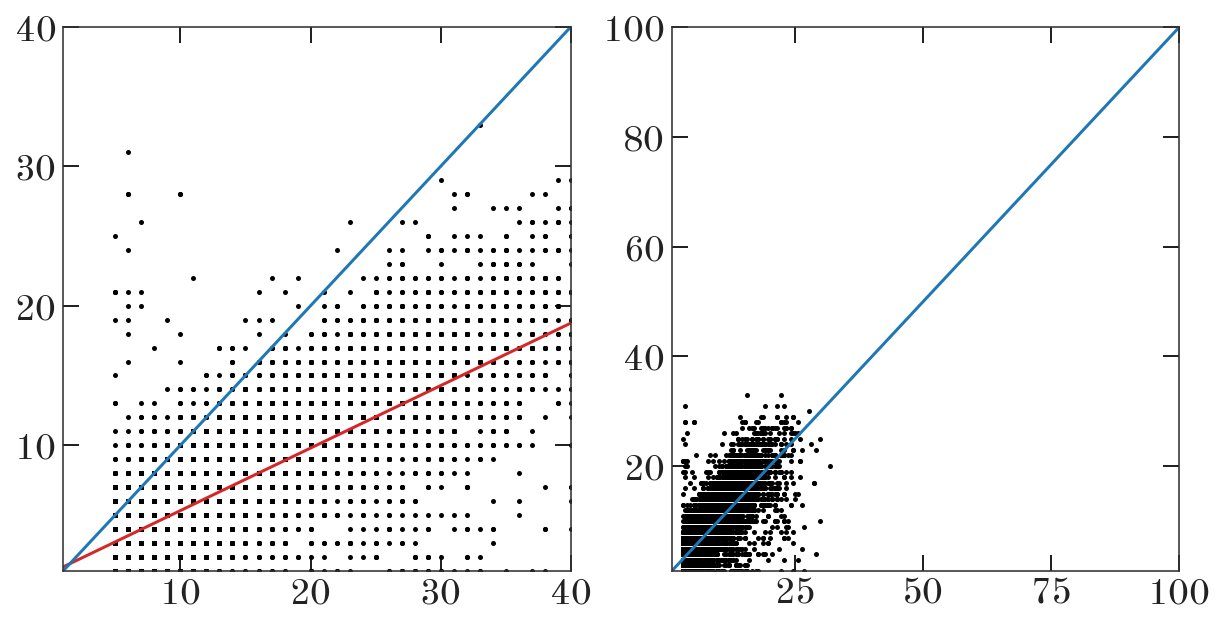

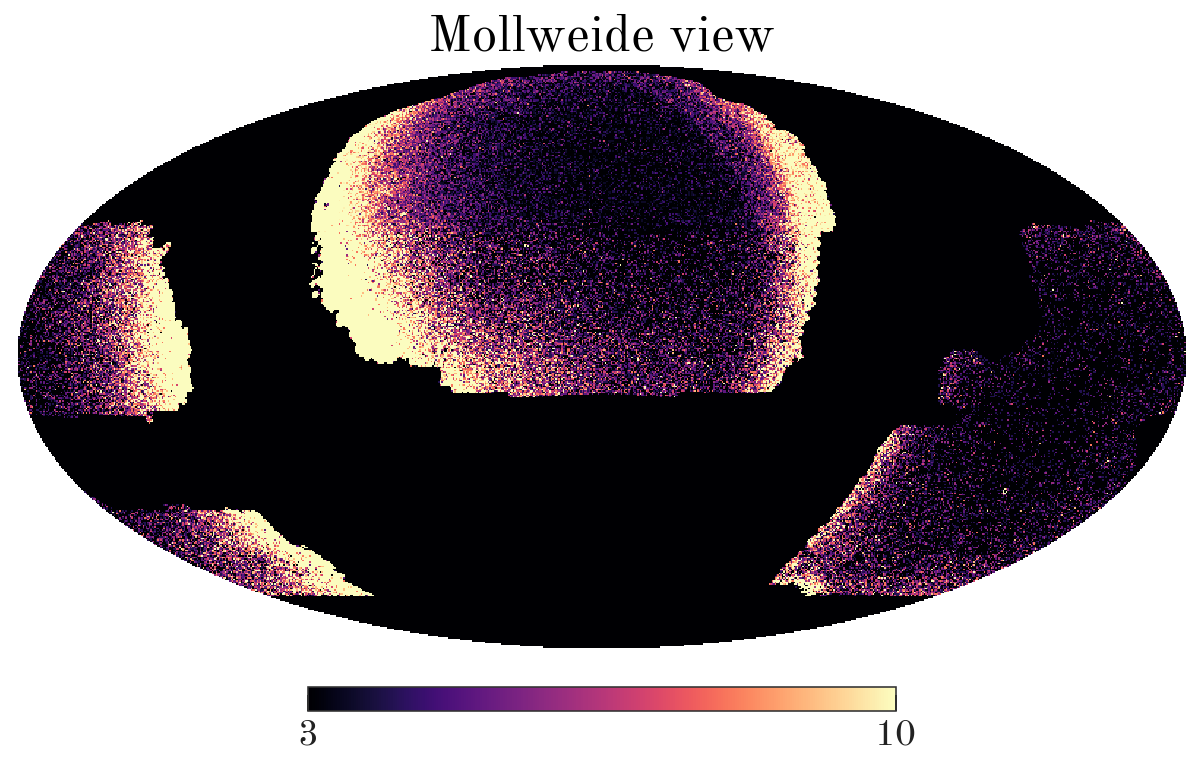

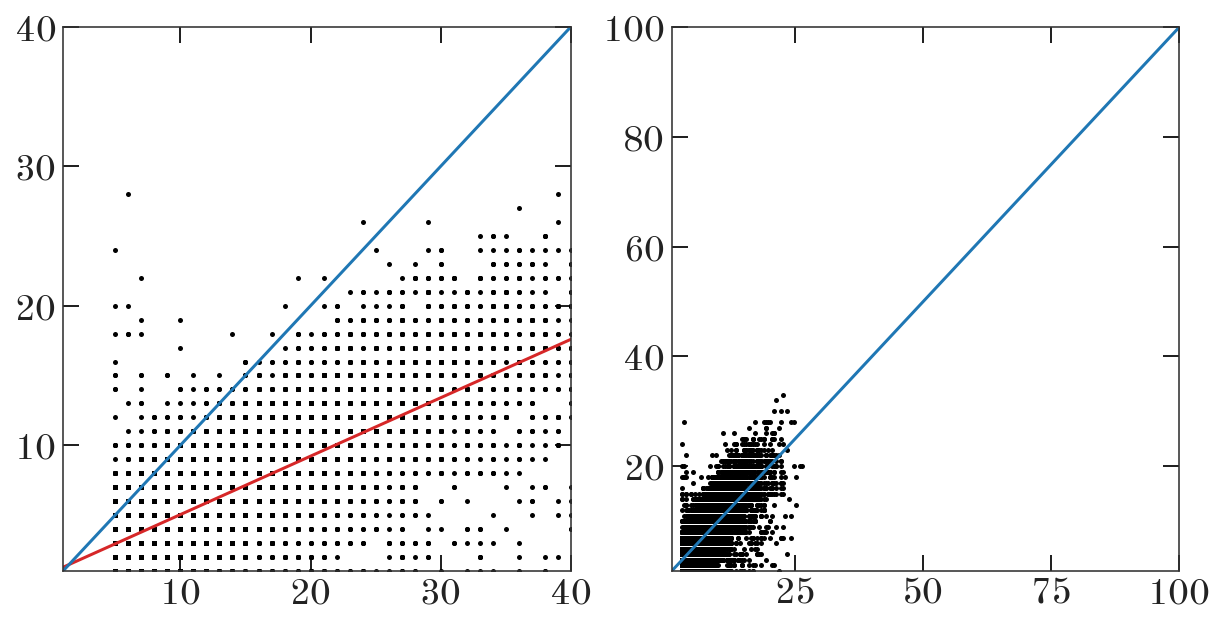

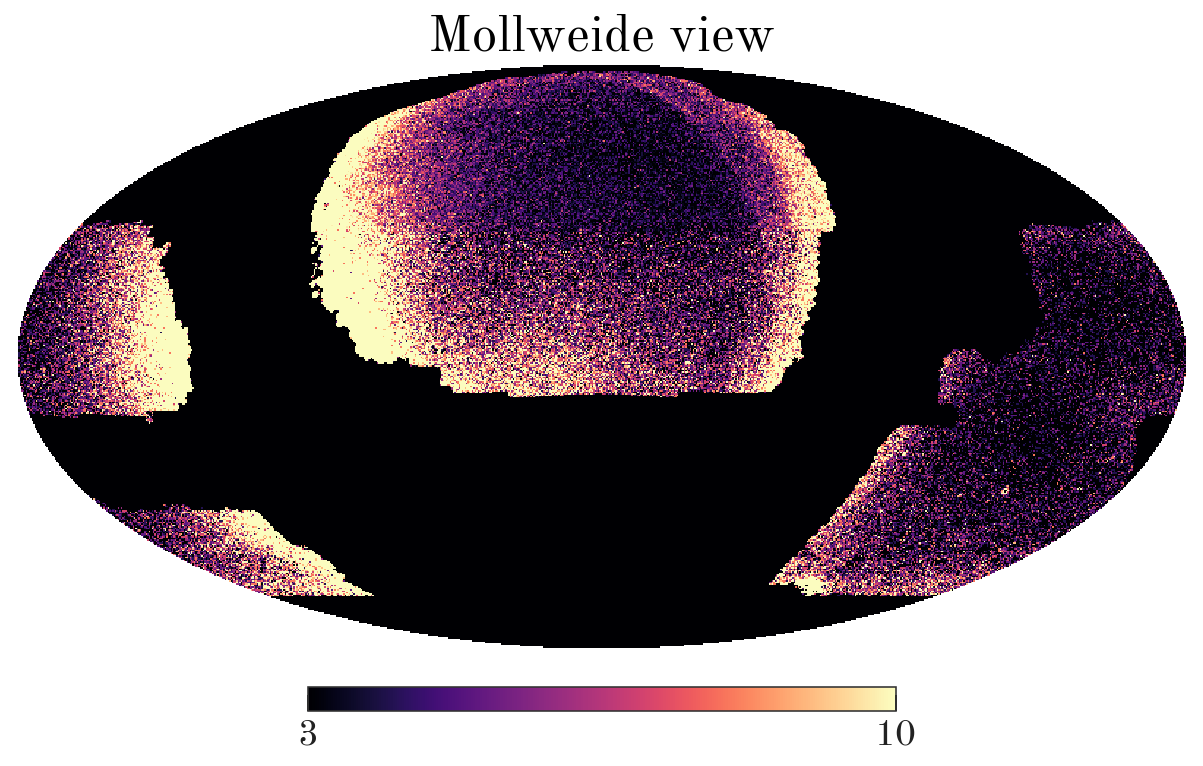

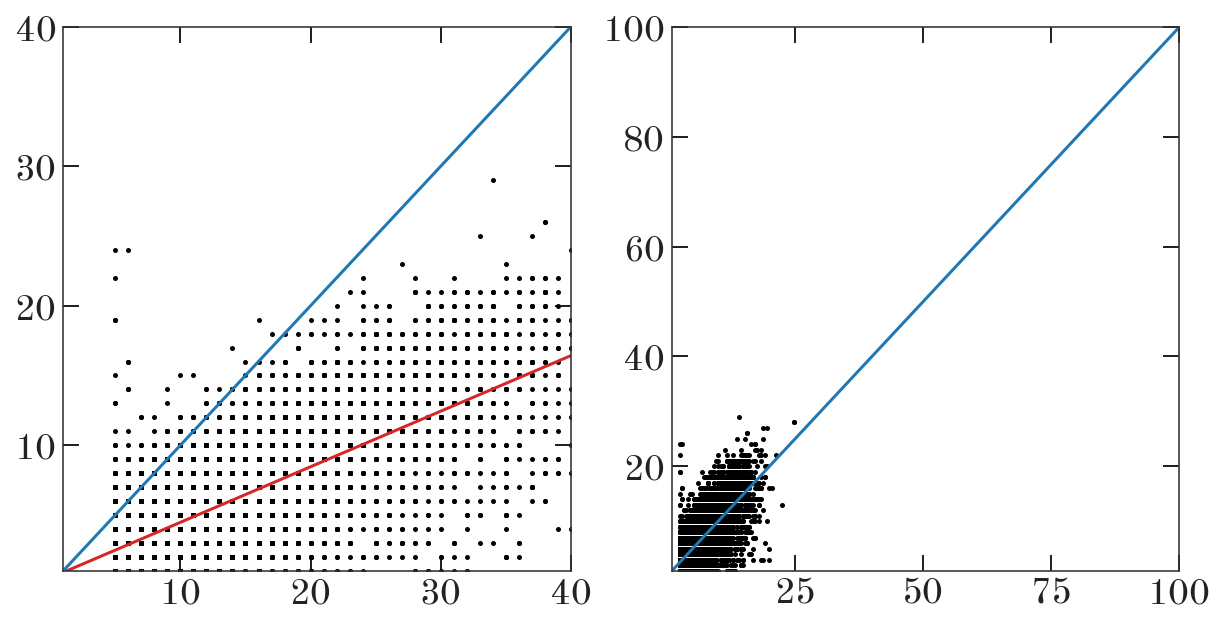

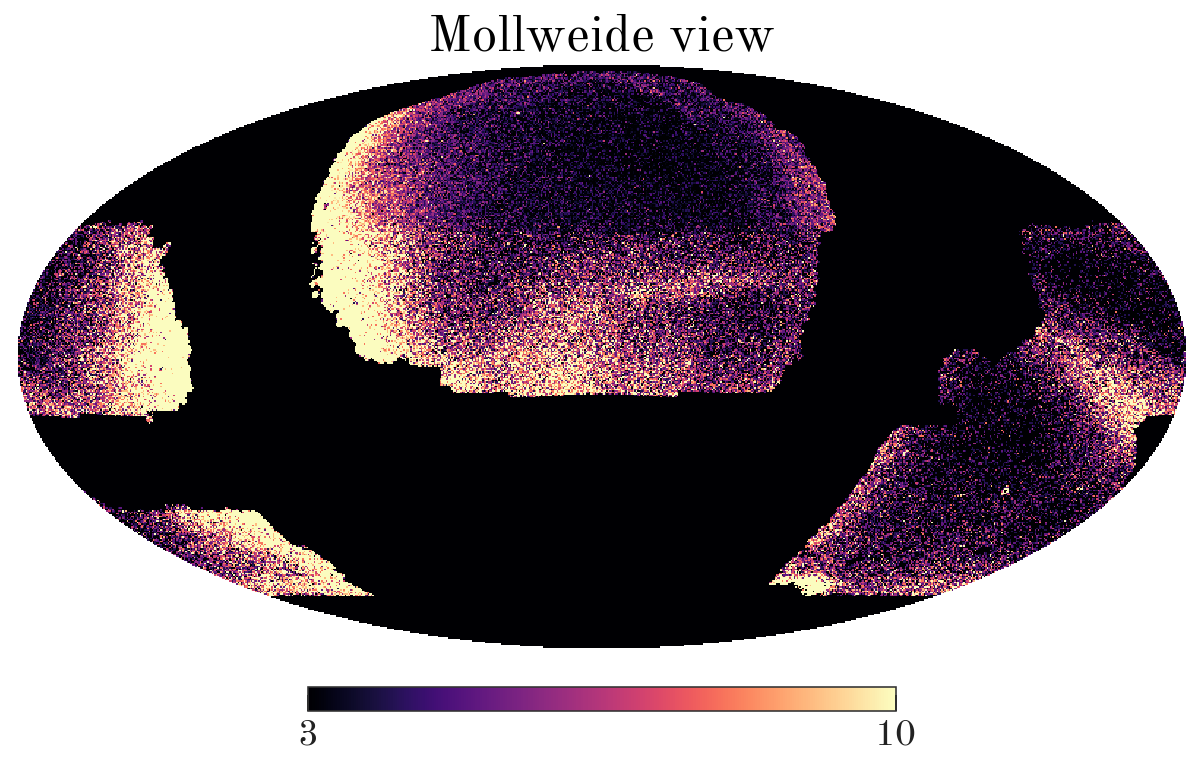

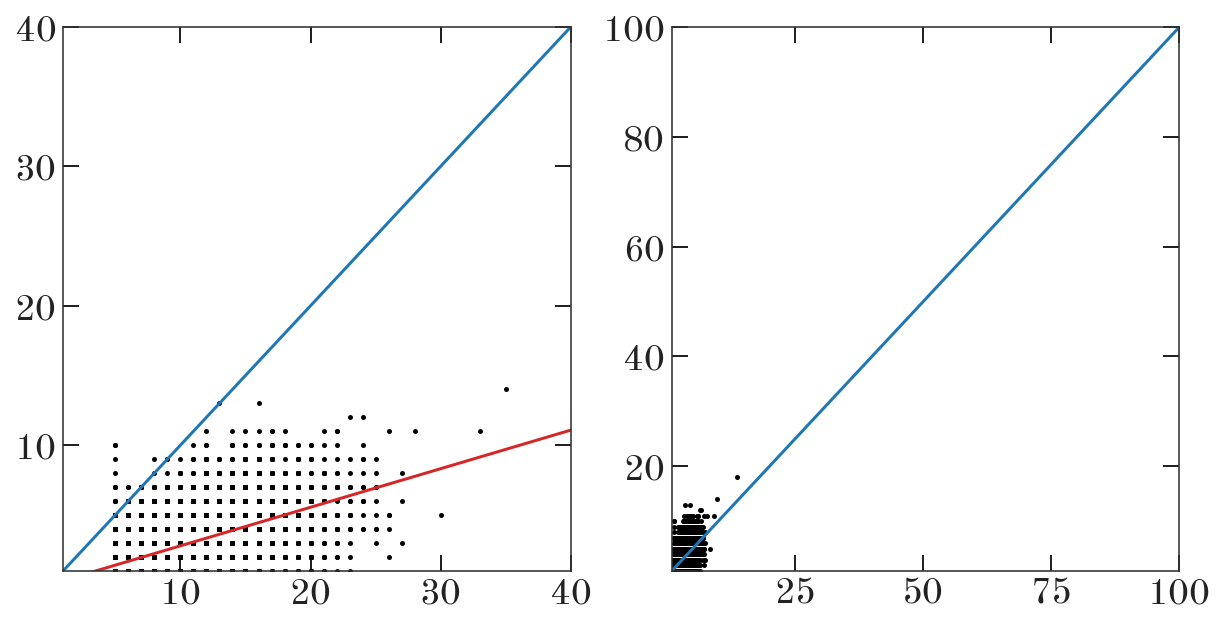

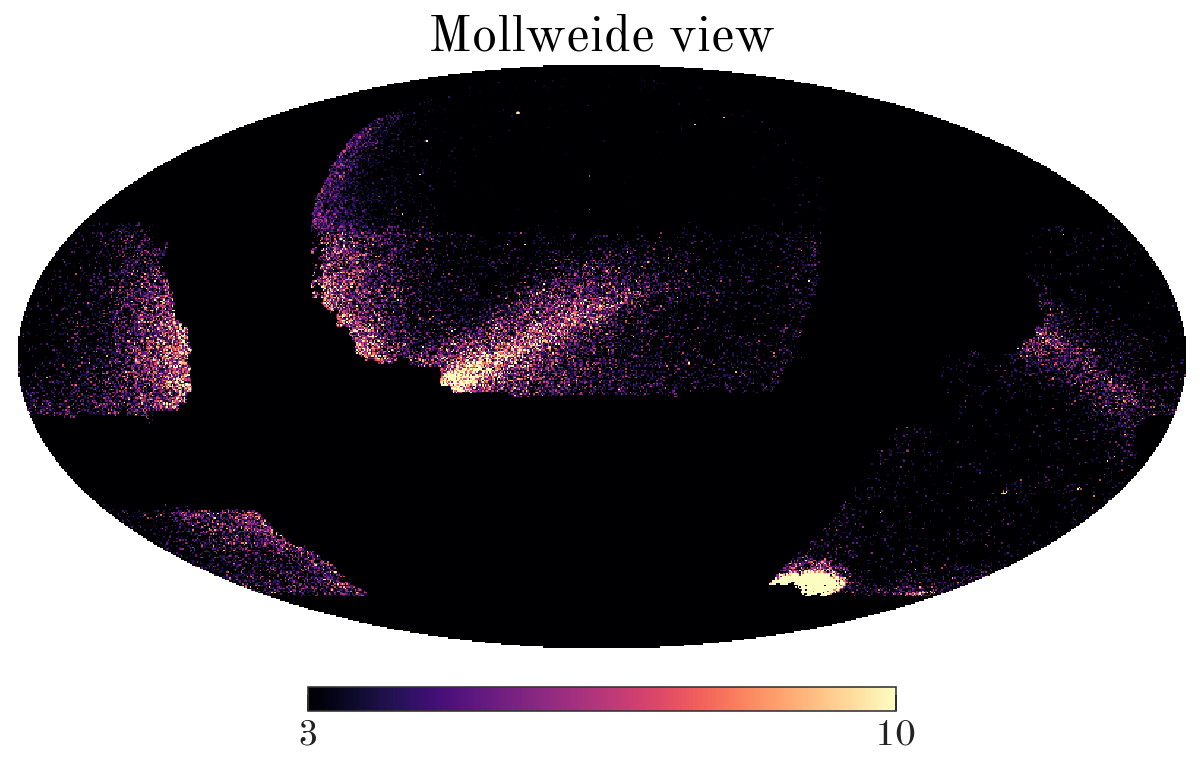

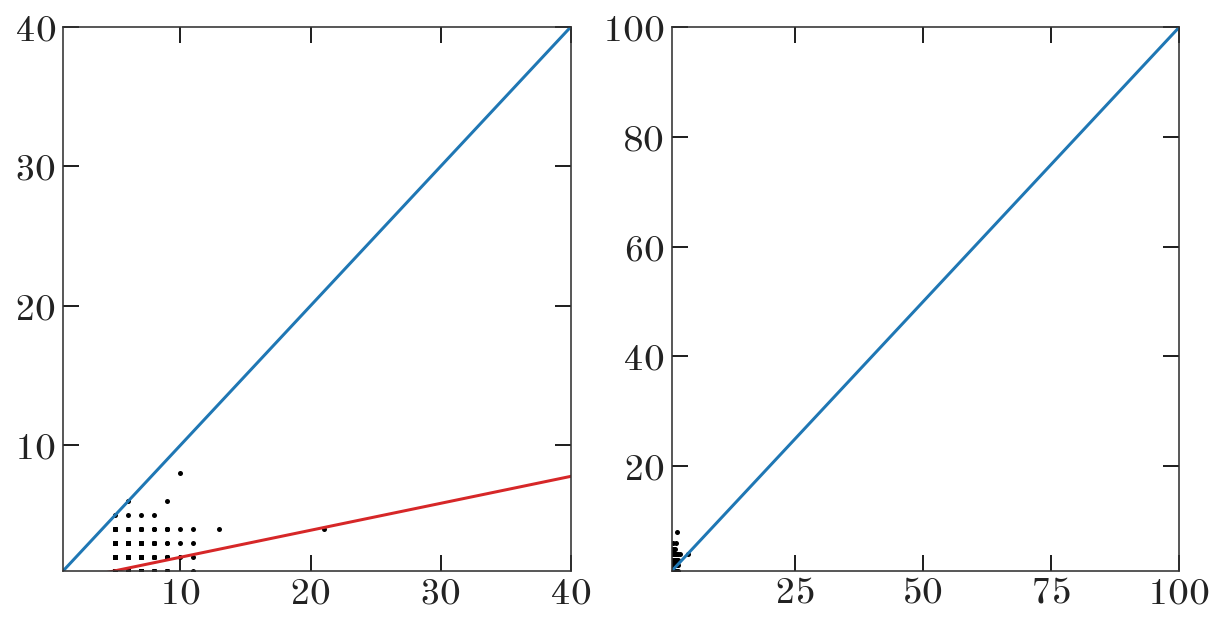

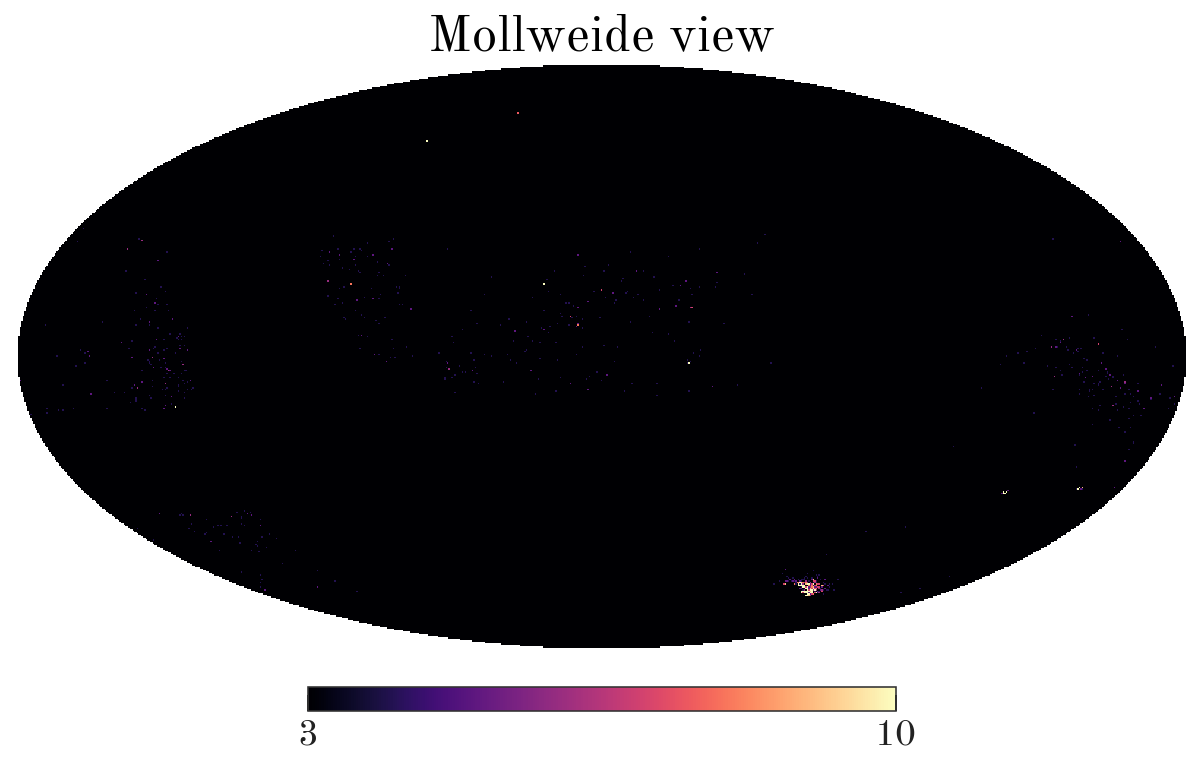

In [180]:
for i in [0, 10, 20, 40, 50]:
    mask = ((cubes['bass'][:, i] > 4) & (cubes['decals'][:, i] > -1) 
            # & (cubes['decals'][:, i] < 40) 
            & overlap)
    # poly = np.poly1d(np.polyfit(
    #     np.log(cubes['bass'][mask, i]), 
    #     np.log(cubes['decals'][mask, i] / cubes['bass'][mask, i]),
    #     deg=5))
    
    poly = np.poly1d(np.polyfit(
        cubes['bass'][mask, i], 
        cubes['decals'][mask, i],
        deg=1))
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    ax = axes[0]
    ax.plot(cubes['bass'][mask, i], 
            cubes['decals'][mask, i], 
            ls='none')
    
    xx = np.logspace(0, 2, 128)
    ax.plot(xx, poly(xx), marker='', color='tab:red')
    ax.plot(xx, xx, marker='', color='tab:blue')
    
    ax.set_xlim(1, 40)
    ax.set_ylim(1, 40)
    
    ax = axes[1]
    new_bass = poly(cubes['bass'][:, i])
    ax.plot(new_bass[mask], 
            cubes['decals'][mask, i], 
            ls='none')
    
    ax.plot(xx, xx, marker='', color='tab:blue')
    
    ax.set_xlim(1, 1e2)
    ax.set_ylim(1, 1e2)
    
    # --- 
    
    stitched = cubes['decals'][:, i].copy()
    stitched[footprints['bass']] += new_bass[footprints['bass']]
    stitched[overlap] *= 0.5
    
    hp.mollview(stitched, min=3, max=10, rot=[180, 0])